# Model

## Common_Model


In [33]:

import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
#from Model import TIMNET_Model
import argparse



In [34]:

import sys

class Common_Model(object):

    def __init__(self, save_path: str = '', name: str = 'Not Specified'):
        self.model = None
        self.trained = False 

    def train(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError()

    def predict(self, samples):
        raise NotImplementedError()
        

    def predict_proba(self, samples):
        if not self.trained:
            sys.stderr.write("No Model.")
            sys.exit(-1)
        return self.model.predict_proba(samples)

    def save_model(self, model_name: str):
        raise NotImplementedError()

## Model Architecture


In [35]:

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.layers import Conv1D, SpatialDropout1D,add,GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import sigmoid

def Temporal_Aware_Block(x, s, i, activation, nb_filters, kernel_size, dropout_rate=0, name=''):

    original_x = x
    #1.1
    conv_1_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(x)
    conv_1_1 = BatchNormalization(trainable=True,axis=-1)(conv_1_1)
    conv_1_1 =  Activation(activation)(conv_1_1)
    output_1_1 =  SpatialDropout1D(dropout_rate)(conv_1_1)
    # 2.1
    conv_2_1 = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(output_1_1)
    conv_2_1 = BatchNormalization(trainable=True,axis=-1)(conv_2_1)
    conv_2_1 = Activation(activation)(conv_2_1)
    output_2_1 =  SpatialDropout1D(dropout_rate)(conv_2_1)
    
    if original_x.shape[-1] != output_2_1.shape[-1]:
        original_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(original_x)
        
    output_2_1 = Lambda(sigmoid)(output_2_1)
    F_x = Lambda(lambda x: tf.multiply(x[0], x[1]))([original_x, output_2_1])
    return F_x


class TIMNET:
    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation = "relu",
                 dropout_rate=0.1,
                 return_sequences=True,
                 name='TIMNET'):
        self.name = name
        self.return_sequences = return_sequences
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters

        self.supports_masking = True
        self.mask_value=0.

        if not isinstance(nb_filters, int):
            raise Exception()

    def __call__(self, inputs, mask=None):
        if self.dilations is None:
            self.dilations = 8
        forward = inputs
        backward = K.reverse(inputs,axes=1)
        
        print("Input Shape=",inputs.shape)
        forward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(forward)
        backward_convd = Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')(backward)
        
        final_skip_connection = []
        
        skip_out_forward = forward_convd
        skip_out_backward = backward_convd
        
        for s in range(self.nb_stacks):
            for i in [2 ** i for i in range(self.dilations)]:
                skip_out_forward = Temporal_Aware_Block(skip_out_forward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                skip_out_backward = Temporal_Aware_Block(skip_out_backward, s, i, self.activation,
                                                        self.nb_filters,
                                                        self.kernel_size, 
                                                        self.dropout_rate,  
                                                        name=self.name)
                
                temp_skip = add([skip_out_forward, skip_out_backward],name = "biadd_"+str(i))
                temp_skip=GlobalAveragePooling1D()(temp_skip)
                temp_skip=tf.expand_dims(temp_skip, axis=1)
                final_skip_connection.append(temp_skip)

        output_2 = final_skip_connection[0]
        for i,item in enumerate(final_skip_connection):
            if i==0:
                continue
            output_2 = K.concatenate([output_2,item],axis=-2)
        x = output_2

        return x

## TIMNET_MODEL

In [36]:

import numpy as np
import tensorflow.keras.backend as K
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Layer,Dense,Input
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
#from Common_Model import Common_Model
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import datetime
import pandas as pd

#from TIMNET import TIMNET


In [66]:

def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

class WeightLayer(Layer):
    def __init__(self, **kwargs):
        super(WeightLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1],1),
                                      initializer='uniform',
                                      trainable=True)  
        super(WeightLayer, self).build(input_shape)  
 
    def call(self, x):
        tempx = tf.transpose(x,[0,2,1])
        x = K.dot(tempx,self.kernel)
        x = tf.squeeze(x,axis=-1)
        return  x
 
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])
    
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    returnval = ex/K.sum(ex, axis=axis, keepdims=True)
    print("returnval is: ")
    print(returnval)
    return ex/K.sum(ex, axis=axis, keepdims=True)

class TIMNET_Model(Common_Model):
    def __init__(self, args, input_shape, class_label, **params):
        super(TIMNET_Model,self).__init__(**params)
        self.args = args
        self.data_shape = input_shape
        self.num_classes = len(class_label)
        self.class_label = class_label
        self.matrix = []
        self.eva_matrix = []
        self.acc = 0
        print("TIMNET MODEL SHAPE:",input_shape)
    
    def create_model(self):
        self.inputs=Input(shape = (self.data_shape[0],self.data_shape[1]))
        print(self.inputs.shape)
        self.multi_decision = TIMNET(nb_filters=self.args.filter_size,
                                kernel_size=self.args.kernel_size, 
                                nb_stacks=self.args.stack_size,
                                dilations=self.args.dilation_size,
                                dropout_rate=self.args.dropout,
                                activation = self.args.activation,
                                return_sequences=True, 
                                name='TIMNET')(self.inputs)
        
        self.decision = WeightLayer()(self.multi_decision)
        
        self.predictions = Dense(self.num_classes, activation='softmax')(self.decision)
        self.model = Model(inputs = self.inputs, outputs = [ self.predictions])
        
        self.model.compile(loss = "categorical_crossentropy",
                           optimizer =Adam(learning_rate=self.args.lr, beta_1=self.args.beta1, beta_2=self.args.beta2, epsilon=1e-8),
                           metrics = ['accuracy'])
        print("Temporal create succes!")
        
   
   
    def test_one_sample(self, sample , framebyframe,path):
        # if audio is split to frames framebyframe must be True. 

        if framebyframe:
            y_pred_best = self.model_avg(sample,path)  
            transposed_probabilities = np.transpose(y_pred_best)
            #for printing out each emotion probability graph seperately
            n_classes = len(self.class_label)
            fig, axes = plt.subplots(3, 3, figsize=(6, 6))  
            axes = axes.flatten()
            plt.suptitle("Emotion Probabilities")
            plt.xlabel('Samples')
            plt.ylabel('Probability')
            for i, class_name in enumerate(self.class_label):
                m = i % 3
                n = i / 3
                axes[i].plot(transposed_probabilities[i], label=class_name)
                axes[i].set_title(class_name)
                axes[i].set_ylim(0, 1)
            plt.tight_layout() 
            plt.savefig('output_single.png')
            plt.show()

            #for printing out emotions together. 
            colors = ["r", "c", "g", "y", "m", "b", "k", "orange"] 
            plt.figure(figsize=(30,20))
            n=100
            for i, class_name in enumerate(self.class_label):
                plt.plot(np.arange(y_pred_best.shape[0]), transposed_probabilities[i], label=class_name, color=colors[i])
                #plt.plot(np.arange(0, y_pred_best.shape[0], n), transposed_probabilities[i][::n], label=class_name, color=colors[i])

            plt.xlabel('Sample index')
            plt.ylabel('Probabilities')
            plt.ylim(0, 1)
            plt.legend() 
            plt.title('Emotion Probabilities for Each Class')
            plt.savefig('output.png')
            plt.show()

        else: 
            y_pred_best = self.model.predict(np.expand_dims(sample, 0))
            print("y_predictions are: ")
            print(y_pred_best)
        
        
        return y_pred_best  
    
    def model_avg(self,sample, path):
        self.create_model()
        weight_path = path+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(1)+".hdf5"
        self.model.load_weights(weight_path)
        prediction = self.model.predict(sample)
        sum = prediction
        for i in range(2,11):
            self.create_model()
            weight_path = path+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(i)+".hdf5"
            self.model.load_weights(weight_path)
            predictions= self.model.predict(sample)
            sum += predictions
        return sum/10



    def test_two_samples(self, sample1, sample2,path):

        predictions_speaker1 = self.model_avg(sample1,path)
        predictions_speaker2 = self.model_avg(sample2,path)
        
        return predictions_speaker1, predictions_speaker2
    
    def test_multi_speaker(self, sample_dict, speaker_order,path):
        predictions_list = []
        occurence_dict = {}
        for speaker in speaker_order:
            if speaker in occurence_dict:
                occurence_dict[speaker] += 1
            else:
                occurence_dict[speaker] = 0
            mfcc_list = sample_dict[speaker]  
            #prediction = self.model.predict(mfcc_list[occurence_dict[speaker]])
            prediction = self.model_avg(mfcc_list[occurence_dict[speaker]],path)
            print("Type is: ")
            print(type(prediction))
            predictions_list.append(prediction)
        return predictions_list

    def test_original(self, x, y, path, fold):
        i=1
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        avg_accuracy = 0
        avg_loss = 0
        x_feats = []
        y_labels = []
        for train, test in kfold.split(x, y):
            self.create_model()
            weight_path=path+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(i)+".hdf5"
            self.model.fit(x[train], y[train],validation_data=(x[test],  y[test]),batch_size = 64,epochs = 0,verbose=0)
            self.model.load_weights(weight_path)#+source_name+'_single_best.hdf5')
            best_eva_list = self.model.evaluate(x[test],  y[test])
        
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(str(i)+'_Model evaluation: ', best_eva_list,"   Now ACC:",str(round(avg_accuracy*10000)/100/i))
            i+=1
            y_pred_best = self.model.predict(x[test]) 
        
            transposed_probabilities = np.transpose(y_pred_best)
            
            self.matrix.append(confusion_matrix(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1)))
            em = classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label,output_dict=True)
            self.eva_matrix.append(em)
            print(classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label))
            caps_layer_model = Model(inputs=self.model.input,
            outputs=self.model.get_layer(index=-2).output)
            feature_source = caps_layer_model.predict(x[test])
            x_feats.append(feature_source)
            y_labels.append(y[test])
            
        print("Average ACC:",avg_accuracy/self.args.split_fold)
        self.acc = avg_accuracy/self.args.split_fold
        
        return x_feats, y_labels



    def test(self, x, y, path):
        i=1
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        avg_accuracy = 0
        avg_loss = 0
        x_feats = []
        y_labels = []
        for train, test in kfold.split(x, y):
            self.create_model()
            weight_path=path+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(i)+".hdf5"
            self.model.fit(x[train], y[train],validation_data=(x[test][0],  y[test][0]),batch_size = 64,epochs = 0,verbose=0)
            self.model.load_weights(weight_path)#+source_name+'_single_best.hdf5')
            best_eva_list = self.model.evaluate(np.expand_dims(x[test][0], 0), np.expand_dims(y[test][0], 0))
            #best_eva_list = self.model.evaluate(x[test][0],  y[test][0])
            x_test = x[test]
            x_test0 = x_test[0]
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(str(i)+'_Model evaluation: ', best_eva_list,"   Now ACC:",str(round(avg_accuracy*10000)/100/i))
            i+=1
            y_pred_best = self.model.predict(np.expand_dims(x[test][0], 0))
            print("y_pred_best is: ")
            print(y_pred_best)
            print(y[test][0])
            break
        return x_feats, y_labels
    

    def train(self, x, y):

        filepath = self.args.model_path
        resultpath = self.args.result_path

        if not os.path.exists(filepath):
            os.mkdir(filepath)
        if not os.path.exists(resultpath):
            os.mkdir(resultpath)

        i=1
        now = datetime.datetime.now()
        now_time = datetime.datetime.strftime(now,'%Y-%m-%d_%H-%M-%S')
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        avg_accuracy = 0
        avg_loss = 0
        for train, test in kfold.split(x, y):
            self.create_model()
            y[train] = smooth_labels(y[train], 0.1)
            folder_address = filepath+self.args.data+"_"+str(self.args.random_seed)+"_"+now_time
            if not os.path.exists(folder_address):
                os.mkdir(folder_address)
            weight_path=folder_address+'/'+str(self.args.split_fold)+"-fold_weights_best_"+str(i)+".hdf5"
            checkpoint = callbacks.ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1,save_weights_only=True,save_best_only=True,mode='max')
            max_acc = 0
            best_eva_list = []
            h = self.model.fit(x[train], y[train],validation_data=(x[test],  y[test]),batch_size = self.args.batch_size, epochs = self.args.epoch, verbose=1,callbacks=[checkpoint])
            self.model.load_weights(weight_path)
            best_eva_list = self.model.evaluate(x[test],  y[test])
            avg_loss += best_eva_list[0]
            avg_accuracy += best_eva_list[1]
            print(str(i)+'_Model evaluation: ', best_eva_list,"   Now ACC:",str(round(avg_accuracy*10000)/100/i))
            i+=1
            y_pred_best = self.model.predict(x[test])
            self.matrix.append(confusion_matrix(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1)))
            em = classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label,output_dict=True)
            self.eva_matrix.append(em)
            print(classification_report(np.argmax(y[test],axis=1),np.argmax(y_pred_best,axis=1), target_names=self.class_label))

        print("Average ACC:",avg_accuracy/self.args.split_fold)
        self.acc = avg_accuracy/self.args.split_fold
        writer = pd.ExcelWriter(resultpath+self.args.data+'_'+str(self.args.split_fold)+'fold_'+str(round(self.acc*10000)/100)+"_"+str(self.args.random_seed)+"_"+now_time+'.xlsx')
        for i,item in enumerate(self.matrix):
            temp = {}
            temp[" "] = self.class_label
            for j,l in enumerate(item):
                temp[self.class_label[j]]=item[j]
            data1 = pd.DataFrame(temp)
            data1.to_excel(writer,sheet_name=str(i), encoding='utf8')

            df = pd.DataFrame(self.eva_matrix[i]).transpose()
            df.to_excel(writer,sheet_name=str(i)+"_evaluate", encoding='utf8')
        writer.save()
        writer.close()

        K.clear_session()
        self.matrix = []
        self.eva_matrix = []
        self.acc = 0
        self.trained = True



# Utility Functions

## Feature Extraction


In [38]:
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf


In [39]:
def display_mfccs(mfccs):
    plt.figure(figsize= (10,4))
    librosa.display.specshow(mfccs, x_axis = "time" )
    plt.colorbar(format = "%+2.0f ")
    plt.show

In [40]:
def get_framed(y ,sr, frame_length, skip_length):
    frame_length_samples = int(frame_length * sr)
    skip_length_samples = int(skip_length * sr)

    frames = []

    if len(y) <= frame_length_samples:
        pad_length = frame_length_samples - len(y)
        y = np.pad(y, (0, pad_length), 'constant', constant_values=0) 
        frames.append(y)
        return frames, sr
    
    for i in range(0, len(y) - frame_length_samples, skip_length_samples):
        frame = y[i:i+frame_length_samples]
        frames.append(frame)

    return frames, sr
    

In [41]:

def get_feature_frompath(version, file_path = str , mfcc_len: int = 39):
  	  ## """
      ## file_path: Speech signal folder
      ##mfcc_len: MFCC coefficient length
      ##mean_signal_length: MFCC feature average length
  	  ##"""
      
    signal, fs = librosa.load(file_path)
    s_len = len(signal)

    if version== "RAVDE":
        mean_signal_length =110000
    if version == "IEMOCAP":
        mean_signal_length = 310000

    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values = 0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    mfcc = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=39)
    mfcc = mfcc.T
    feature = mfcc
    return feature

In [42]:
def get_feature_fromsignal(signal , fs,version, mfcc_len: int = 39,):
  	  ## """
      ## file_path: Speech signal folder
      ##mfcc_len: MFCC coefficient length
      ##mean_signal_length: MFCC feature average length
  	  ##"""
      
    s_len = len(signal)
    if version== "RAVDE":
        mean_signal_length =110000
    if version == "IEMOCAP":
        mean_signal_length = 310000

    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values = 0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
    mfcc = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=39)
    mfcc = mfcc.T
    feature = mfcc
    return feature

In [43]:
def get_features_fromframes(y,sr,frame_length,skip_length,version):
    frames, sr = get_framed(y,sr,frame_length,skip_length)
    mfccs = [get_feature_fromsignal(frame,sr,version) for frame in frames]   
    mfccs_np = np.stack(mfccs) 
    return mfccs_np

## Audio Manipulations

In [44]:
def concatenate_audios(audio1,audio2,combined_audio_name):

    y1, sr1 = librosa.load(audio1)
    y2, sr2 = librosa.load(audio2)

    assert sr1 == sr2, "Sample rates (sr) must be the same to concatenate the audios."

    y = np.concatenate([y1, y2])
    sf.write(combined_audio_name, y, sr1)


In [45]:
def get_speaker_order_from_duration(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    speaker_order = []
    for line in lines:
        _, speaker = line.split(",")
        speaker_order.append(speaker.strip()) 
    
    return speaker_order

In [46]:
def separate_multi_speakers(audiopath, durations_file, num_speakers):

    y,sr = librosa.load(audiopath)
    speakers_segments = {f'speaker{i+1}': [] for i in range(num_speakers)} #dictionary of speakers and their parts.

    with open(durations_file, 'r') as file:
        for line in file:
            time_range, speaker = line.strip().split(' , ')

            start_time_str, end_time_str = time_range.split(' - ')
            start_min, start_sec = map(int, start_time_str.split(':'))
            end_min, end_sec = map(int, end_time_str.split(':'))

            start_sample = ((start_min * 60) + start_sec) * sr
            end_sample = ((end_min * 60) + end_sec) * sr

            segment = y[start_sample:end_sample]

            if speaker.strip() in speakers_segments:
                speakers_segments[speaker.strip()].append(segment)
    
    return speakers_segments, sr 

In [47]:
def seperate_two_speakers(audio_path, durations_file):
    y, sr = librosa.load(audio_path)

    speaker1_segments = []
    speaker2_segments = []

    with open(durations_file, 'r') as file:
        for line in file:
            time_range, speaker = line.strip().split(' , ')

            start_time_str, end_time_str = time_range.split(' - ')
            start_min, start_sec = map(int, start_time_str.split(':'))
            end_min, end_sec = map(int, end_time_str.split(':'))

            start_sample = ((start_min * 60) + start_sec) * sr
            end_sample = ((end_min * 60) + end_sec) * sr

            segment = y[start_sample:end_sample]

            if speaker.strip() == 'speaker1':
                speaker1_segments.append(segment)
            else:
                speaker2_segments.append(segment)

    # speaker1_audio = np.concatenate(speaker1_segments)
    # speaker2_audio = np.concatenate(speaker2_segments)

    # output_file_speaker1 = audio_path.split('.')[0] + '_speaker1.wav'
    # output_file_speaker2 = audio_path.split('.')[0] + '_speaker2.wav'

    # sf.write(output_file_speaker1, speaker1_audio, sr)
    # sf.write(output_file_speaker2, speaker2_audio, sr)

    return speaker1_segments, speaker2_segments ,sr

In [48]:
def seperate_speakers_static(signalpath, duration):  #use only if two speakers speak for exactly same duration. For example if each speaker speaks for 8 seconds in an alternating way, then duration is 8.
    
    y, sr = librosa.load(signalpath)

    num_samples_8_sec = sr * duration

    speaker1_samples = []
    speaker2_samples = []

    for idx, start_sample in enumerate(range(0, len(y), num_samples_8_sec)):
        end_sample = start_sample + num_samples_8_sec

        slice = y[start_sample:end_sample]

        if idx % 2 == 0:
            speaker1_samples.append(slice)
        else:
            speaker2_samples.append(slice)

    #uncomment if want to download the speaker audios as one. 
   # speaker1_audio = np.concatenate(speaker1_samples)
   #  speaker2_audio = np.concatenate(speaker2_samples)

   # filename_base = os.path.splitext(os.path.basename(signalpath))[0]

    # speaker1_output = filename_base + '_speaker1.wav'
    # speaker2_output = filename_base + '_speaker2.wav'

    # sf.write(speaker1_output, speaker1_audio, sr)
    # sf.write(speaker2_output, speaker2_audio, sr)
    
     
    return speaker1_samples, speaker2_samples,sr

## Visualization


In [71]:
def visualize_twospeaker_predictions(class_labels, y_pred_best1, y_pred_best2):

        transposed_probabilities1 = np.transpose(y_pred_best1)
        transposed_probabilities2 = np.transpose(y_pred_best2)
    
        colors = ["r", "c", "g", "y", "m", "b", "k", "orange"]
        marker = ['s', '^']  
        lines = []
        labels = []

        plt.figure(figsize=(20,12))
        for i, class_name in enumerate(class_labels):
            line1, = plt.plot(np.arange(y_pred_best1.shape[0]), transposed_probabilities1[i], label=class_name, color=colors[i], marker=marker[0])
            #line2, = plt.plot(np.arange(y_pred_best2.shape[0]), transposed_probabilities2[i], label=class_name, color=colors[i], marker=marker[1])    
            line2, = plt.plot(np.arange(0.5, y_pred_best2.shape[0]+0.5), transposed_probabilities2[i], label=class_name, color=colors[i], marker=marker[1])  # Adjusted for speaker2
            if i == 0:  
                lines.append(line1)
                lines.append(line2)
                labels.append('Speaker1')
                labels.append('Speaker2')

        plt.xlabel('Sample index')
        plt.ylabel('Probabilities')

        leg1 = plt.legend(lines, labels, title='Speakers', loc='upper left')

        emotions = [plt.Line2D([0], [0], color=c, lw=4) for c in colors]
        leg2 = plt.legend(emotions, class_labels, title='Emotions', loc='lower left')

        plt.gca().add_artist(leg1)  
        plt.title('Emotion Probabilities for Each Class')
        plt.savefig('output.png')
        plt.ylim(0,1)
        plt.show()

In [72]:
def visualize_multispeaker_predictions(class_labels, y_preds_list, duration_order):
        colors = ["r", "c", "g", "y", "m", "b", "k", "orange"]
        marker = ['s', '^', 'o', 'D', '*', 'p']
        lines = []
        labels = []

        plt.figure(figsize=(20, 12))

        current_x_position = 0  

        # dictionary maps each unique speaker to a marker
        unique_speakers = list(set(duration_order))
        speaker_to_marker = {speaker: marker[i % len(marker)] for i, speaker in enumerate(unique_speakers)}

        added_speakers = set()  # to track which speakers are added to the legend

        for idx, y_pred in enumerate(y_preds_list):
            transposed_probabilities = np.transpose(y_pred)
            current_speaker = duration_order[idx]  # Get the speaker from the duration order
            current_marker = speaker_to_marker[current_speaker]  # Get the marker for the speaker

            for i, class_name in enumerate(class_labels):
                x_values = np.arange(current_x_position, current_x_position + len(y_pred))
                line, = plt.plot(x_values, transposed_probabilities[i], label=class_name if idx == 0 else "", color=colors[i], marker=current_marker)
                
                if i == 0 and current_speaker not in added_speakers:
                    lines.append(line)
                    labels.append(current_speaker)
                    added_speakers.add(current_speaker)

            current_x_position += len(y_pred)  # Increase the x_position for the next speaker

        plt.xlabel('Sample index')
        plt.ylabel('Probabilities')
        plt.ylim(0,1)


        leg1 = plt.legend(lines, labels, title='Speakers', loc='upper left')  #legend for speaker markers

        emotions = [plt.Line2D([0], [0], color=c, lw=4) for c in colors]  #legend for emotions
        leg2 = plt.legend(emotions, class_labels, title='Emotions', loc='lower left')

        plt.gca().add_artist(leg1)
        plt.title('Emotion Probabilities for Each Class')
        plt.savefig('output.png')
        plt.show()

In [51]:
def count_speakers_from_duration_file(file_path):

    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    speakers = set()
    
    for line in lines:
        _, speaker = line.split(',')
        speakers.add(speaker.strip())
    
    return len(speakers)



# MAIN


In [67]:
def main(audio_file ,duration_file,model_type=1):
  
    parser = argparse.ArgumentParser()

    parser.add_argument('--mode', type=str, default="test")
    parser.add_argument('--model_path', type=str, default='./Models/')
    parser.add_argument('--result_path', type=str, default='./Results/')
    parser.add_argument('--test_path', type=str, default='./Test_Models/EMODB_46')
    parser.add_argument('--data', type=str, default='RAVDE')
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--beta1', type=float, default=0.93)
    parser.add_argument('--beta2', type=float, default=0.98)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--epoch', type=int, default=60)
    parser.add_argument('--dropout', type=float, default=0.1)
    parser.add_argument('--random_seed', type=int, default=46)
    parser.add_argument('--activation', type=str, default='relu')
    parser.add_argument('--filter_size', type=int, default=39)
    parser.add_argument('--dilation_size', type=int, default=10)
    parser.add_argument('--kernel_size', type=int, default=2)
    parser.add_argument('--stack_size', type=int, default=1)
    parser.add_argument('--split_fold', type=int, default=10)


    dataset_paths = {  "IEMOCAP" : './Test_Models/IEMOCAP_16', "RAVDE" : './Test_Models/RAVDE_46',}

    file = duration_file
    record= audio_file
    num_speakers = count_speakers_from_duration_file(file)

    if model_type==1:
        version = "IEMOCAP"
        path ='./Test_Models/IEMOCAP_16'
        frame_length = 10
        skip_length = 4
        args = parser.parse_args('--mode test --model_path ./Models/ --result_path ./Results/ --test_path ./Test_Models/IEMOCAP_16 --data IEMOCAP --lr 0.001 --beta1 0.93 --beta2 0.98 --batch_size 64 --epoch 60 --dropout 0.1 --random_seed 46 --activation relu --filter_size 39 --dilation_size 10 --kernel_size 2 --stack_size 1 --split_fold 10'.split())

    if model_type==2:
        version = "RAVDE"
        path ='./Test_Models/RAVDE_46'
        frame_length = 5
        skip_length = 2.5
        args = parser.parse_args('--mode test --model_path ./Models/ --result_path ./Results/ --test_path ./Test_Models/RAVDE_46 --data RAVDE --lr 0.001 --beta1 0.93 --beta2 0.98 --batch_size 64 --epoch 60 --dropout 0.1 --random_seed 46 --activation relu --filter_size 39 --dilation_size 8 --kernel_size 2 --stack_size 1 --split_fold 10'.split())
        

    if args.data=="IEMOCAP" and args.dilation_size!=10:
        args.dilation_size = 10
        print("IEMOCAP")

    data = np.load("./MFCC/"+args.data+".npy",allow_pickle=True).item()
    x_source = data["x"]
    y_source = data["y"]

    CLASS_LABELS_finetune = ("angry", "fear", "happy", "neutral","sad")

    RAVDE_CLASS_LABELS = ("angry", "calm", "disgust", "fear", "happy", "neutral","sad","surprise")#rav
    IEMOCAP_CLASS_LABELS = ("angry", "happy", "neutral", "sad")#iemocap

    CLASS_LABELS_dict = { "IEMOCAP": IEMOCAP_CLASS_LABELS, "RAVDE": RAVDE_CLASS_LABELS,  }
    
    CLASS_LABELS = CLASS_LABELS_dict[args.data]

    model = TIMNET_Model(args=args, input_shape=x_source.shape[1:], class_label=CLASS_LABELS)


    if(num_speakers ==1 ):

        y ,sr = librosa.load(record)
        mfcc = get_features_fromframes(y ,sr, frame_length, skip_length,version)
        predictions = model.test_one_sample(mfcc, True,path)

    if(num_speakers ==2):
        speaker1_segments,speaker2_segments, sr = seperate_two_speakers(record,file)
        mfccs_speaker1 = []
        mfccs_speaker2 = []
        for seg in speaker1_segments:
                mfcc_speaker1 = get_features_fromframes(seg,sr, frame_length, skip_length,version)
                mfccs_speaker1.append(mfcc_speaker1)
        for segment in speaker2_segments:
                mfcc_speaker2 = get_features_fromframes(segment ,sr, frame_length, skip_length, version)
                mfccs_speaker2.append(mfcc_speaker2)
        mfccs_speaker1 = np.vstack(mfccs_speaker1)
        mfccs_speaker2 = np.vstack(mfccs_speaker2) 
        y_pred_best1 , y_pred_best2 = model.test_two_samples(mfccs_speaker1, mfccs_speaker2,path)
        visualize_twospeaker_predictions(CLASS_LABELS, y_pred_best1 , y_pred_best2 )

    else:
        speakers_segments, sr = separate_multi_speakers(record,file, num_speakers)
        all_speaker_mfccs = {}
        j = 0
        for speaker, segments in speakers_segments.items():
            if speaker not in all_speaker_mfccs:
                 all_speaker_mfccs[speaker] = []
            for seg in segments:
                mfcc = get_features_fromframes(seg,sr, frame_length, skip_length,version)
                all_speaker_mfccs[speaker].append(mfcc) 
            j +=1
        speaker_order= get_speaker_order_from_duration(file)
        y_pred_list = model.test_multi_speaker(all_speaker_mfccs, speaker_order,path)
        visualize_multispeaker_predictions(CLASS_LABELS, y_pred_list,speaker_order)
    return 
    
        

TIMNET MODEL SHAPE: (606, 39)
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 682ms/step
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 1s/step
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 681ms/step
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 691ms/step
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 688ms/step
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 687ms/step
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 683ms/step
(None, 606, 39)
Input Shape= (None, 606, 39)
Temporal create succes!
1/1 [==============================] - 1s 997ms/st

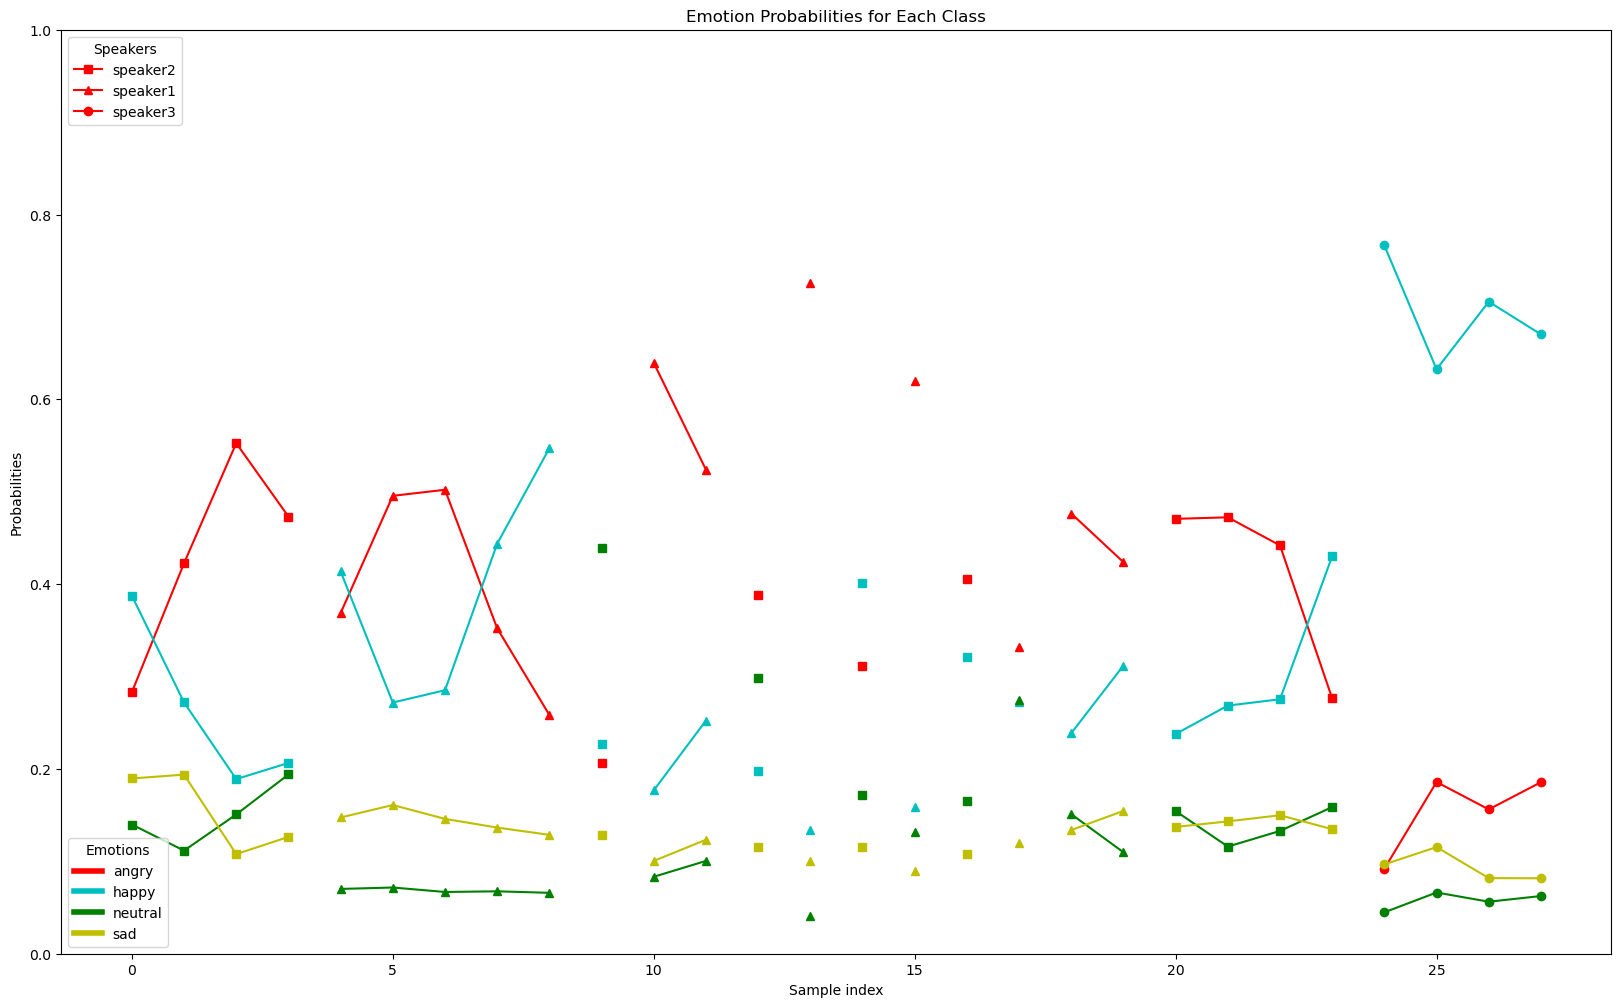

In [75]:
main(audio_file= './', duration_file = './EV_duration.txt' ,model_type=1) 